/var/folders/yw/6fpv_3v11k3brxsw44l9l4bm0000gn/T/ipykernel_97718/1691167028.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns[ticker] = rets
/var/folders/yw/6fpv_3v11k3brxsw44l9l4bm0000gn/T/ipykernel_97718/1691167028.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns[ticker] = rets
/var/folders/yw/6fpv_3v11k3brxsw44l9l4bm0000gn/T/ipykernel_97718/1691167028.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

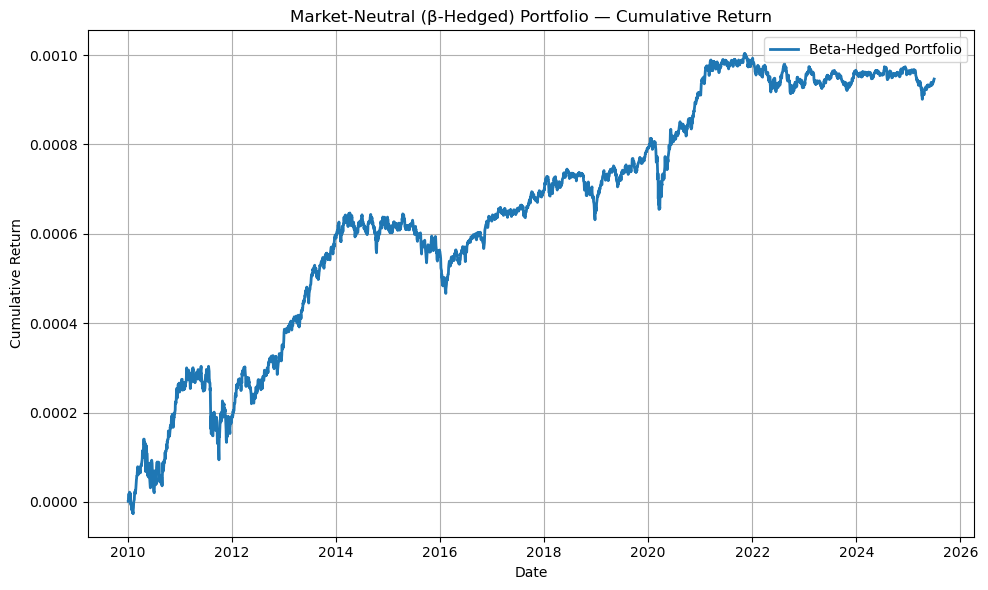

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os

clean_folder = "../cleaned_data/nasdaq"
params_path  = "./parameters.csv"

params = pd.read_csv(params_path, index_col=0)
params = params.dropna(subset=["Beta"])
params = params[np.isfinite(params["Beta"])]

returns = pd.DataFrame()
files = glob.glob(clean_folder.rstrip("/") + "/*.csv")

for file in files:
    ticker = os.path.basename(file).replace(".csv", "")
    if ticker not in params.index:
        continue

    df = pd.read_csv(file, parse_dates=["Date"])
    if "Close" not in df.columns:
        continue

    df = df[["Date", "Close"]].dropna()
    df.set_index("Date", inplace=True)

    rets = df["Close"].pct_change()
    returns[ticker] = rets

returns = returns.dropna(how="all").fillna(0.0)

returns = returns.clip(lower=-0.2, upper=0.2)

betas = params["Beta"].reindex(returns.columns).dropna()
returns = returns[betas.index]

weights = betas / betas.abs().sum()

hedge_factor = (weights * betas).sum()
denom = (betas ** 2).sum()
if denom != 0:
    weights = weights - hedge_factor * betas / denom

gross = weights.abs().sum()
if gross > 0:
    weights = weights / gross

common_tickers = returns.columns.intersection(weights.index)
returns = returns[common_tickers]
weights = weights[common_tickers]

active_counts = (returns != 0).sum(axis=1).replace(0, np.nan)
portfolio_returns = returns.mul(weights, axis=1).sum(axis=1) / active_counts
portfolio_returns = portfolio_returns.dropna()

cumulative_yield = (1 + portfolio_returns).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(cumulative_yield.index, cumulative_yield.values,
         label="Beta-Hedged Portfolio", linewidth=2)
plt.title("Market-Neutral (β-Hedged) Portfolio — Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
